In [1]:
import pandas as pd
import numpy as np
import re
import networkx
from networkx.algorithms.components.connected import connected_components
from collections import defaultdict
import random
import glob
import os
from Bio import SeqIO
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import jaccard_score
import time
start = time.time()

# Loading MIBiG dataframes and creating dictionaries

In [2]:
bioactivity_df = pd.read_csv("./bioactivity_df-220203.csv",sep='\t',index_col=0)

bioactivity_dict = dict(zip(bioactivity_df['metabolite'],bioactivity_df['activity']))

bioactivity_dict

{'abyssomicin': 'antibacterial',
 'aurafuron': 'antifungal-cytotoxic',
 'aureothin': 'antibacterial-antifungal-cytotoxic',
 'avilamycin': 'antibacterial',
 'bafilomycin': 'antibacterial-antifungal-cytotoxic',
 'borrelidin': 'antibacterial-cytotoxic',
 'chlorothricin': 'antibacterial',
 'coelimycin': 'unknown',
 'dawenol': 'unknown',
 'erythromycin': 'antibacterial',
 'galbonolides': 'antifungal',
 'kedarcidin': 'antibacterial-cytotoxic',
 'lactimidomycin': 'antifungal-cytotoxic',
 'neoaureothin': 'antifungal-cytotoxic',
 'neocarzinostatin': 'antibacterial-cytotoxic',
 'nystatin': 'antifungal',
 'pactamycin': 'antibacterial-antifungal-cytotoxic',
 'salinomycin': 'antibacterial-cytotoxic',
 'soraphen': 'antifungal',
 'spirangien': 'antifungal-cytotoxic',
 'sporolide': 'unknown',
 'stambomycin': 'antibacterial-cytotoxic',
 'stigmatellin': 'antifungal',
 'tautomycetin': 'antifungal-cytotoxic',
 'tautomycin': 'antifungal-cytotoxic',
 'tiacumicin': 'antibacterial',
 '9methylstreptimidone': '

In [3]:
np.unique(list(bioactivity_dict.values()))

array(['antibacterial', 'antibacterial-antifungal',
       'antibacterial-antifungal-cytotoxic', 'antibacterial-cytotoxic',
       'antifungal', 'antifungal-cytotoxic', 'cytotoxic',
       'cytotoxic-unknown', 'nan', 'unknown'], dtype='<U34')

In [4]:
mibig_df = pd.read_csv("./All_MIBiG_compounds_with_CF_NPC_classes.txt",sep='\t')

mibig_df

,compound_name,smiles,inchi_key,cf_kingdom,cf_superclass,cf_class,cf_subclass,cf_direct_parent,npc_class,npc_superclass,npc_pathway,npc_isglycoside
0,BGC0000001_abyssomicin C,CC1C[C@]23OC(=O)C4=C2OC1C(O)C3\C=C/C(=O)[C@@H]...,FNEADFUPWHAVTA-UHFFFAOYSA-N,Organic compounds,Organoheterocyclic compounds,Oxanes,NaN,Oxanes,Spirotetronate macrolides,Macrolides,Polyketides,0
1,BGC0000001_atrop-abyssomicin C,CC1CC23OC(=O)C4=C2OC1C(O)C3\C=C/C(=O)C(C)CC(C)...,FNEADFUPWHAVTA-UHFFFAOYSA-N,Organic compounds,Organoheterocyclic compounds,Oxanes,NaN,Oxanes,Spirotetronate macrolides,Macrolides,Polyketides,0
2,BGC0000002_aculeximycin,CCCC(O[C@H]1C[C@](C)(N)[C@H](O)[C@H](C)O1)C(C)...,VJKZKLDZOAFAEE-UHFFFAOYSA-N,Organic compounds,Lipids and lipid-like molecules,Prenol lipids,Terpene glycosides,Diterpene glycosides,NaN,NaN,NaN,1
3,BGC0000003_AF-toxin,CCC(C)C(C(=O)OC(/C=C/C=C/C=C/C(=O)O)C1(CO1)C)O...,ONOBRFRRMLDPES-UHFFFAOYSA-N,Organic compounds,Organic acids and derivatives,Peptidomimetics,Depsipeptides,Depsipeptides,NaN,NaN,NaN,0
4,BGC0000004_aflatoxin G1,[H][C@@]12OC=C[C@]1([H])C1=C(O2)C=C(OC)C2=C1OC...,XWIYFDMXXLINPU-UHFFFAOYSA-N,Organic compounds,Phenylpropanoids and polyketides,Coumarins and derivatives,Furanocoumarins,Difurocoumarolactones,Aflatoxins; Simple coumarins,Chromanes; Coumarins,Polyketides; Shikimates and Phenylpropanoids,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2107,BGC0002034_perquinoline A,C1CC2(C(C3=C(C=C(C=C3O)O)C(N2C1=O)C(=O)NCCCC(=...,CDFQOHHGTNUFPU-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alkaloids,0
2108,BGC0002034_perquinoline B,C1CC2(C(C3=C(C=C(C=C3O)O)C(N2C1=O)C(=O)NCCC(=O...,XHJZZGRZEGUFCM-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alkaloids,0
2109,BGC0002034_perquinoline C,C1CC2(C(C3=C(C=C(C=C3O)O)C(N2C1=O)C(=O)NCCCC(=...,ZNSLKIGPUIPFNC-UHFFFAOYSA-N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Alkaloids,0
2110,BGC0002035_ilicicolin H,CC=CC1C2CC(CCC2C(=CC1C(=O)C3=C(C(=CNC3=O)C4=CC...,BYVVOONSAAQMKI-UHFFFAOYSA-N,Organic compounds,Organoheterocyclic compounds,Pyridines and derivatives,Phenylpyridines,Phenylpyridines,Pyridine alkaloids,Nicotinic acid alkaloids,Alkaloids,0


In [5]:
mibig_activity_dict = {}
missing_mets_list = []

for i,r in mibig_df.iterrows():
    met_name = r['compound_name'].split('_')[1].replace(' ','_').lower().split('_')[0]
    for key in bioactivity_dict.keys():
        if type(key) != float:
            if met_name in key:
                print(r['compound_name'].split('_')[0],met_name,key,bioactivity_dict[key])
                if type(bioactivity_dict[key]) == float:
                    mibig_activity_dict[r['compound_name'].split('_')[0]] = 'unknown'
                else:
                    mibig_activity_dict[r['compound_name'].split('_')[0]] = bioactivity_dict[key]
            else:
                missing_mets_list.append(met_name)

BGC0000001 abyssomicin abyssomicin antibacterial
BGC0000002 aculeximycin aculeximycin antibacterial-antifungal
BGC0000014 ambruticin ambruticin antifungal
BGC0000016 amphotericin amphotericin antifungal
BGC0000020 ansamitocin ansamitocin cytotoxic
BGC0000021 apoptolidin apoptolidin cytotoxic
BGC0000023 aurafuron aurafuron antifungal-cytotoxic
BGC0000024 aureothin aureothin antibacterial-antifungal-cytotoxic
BGC0000024 aureothin neoaureothin antifungal-cytotoxic
BGC0000025 avermectin avermectin cytotoxic
BGC0000026 avilamycin avilamycin antibacterial
BGC0000026 avilamycin avilamycin antibacterial
BGC0000028 bafilomycin bafilomycin antibacterial-antifungal-cytotoxic
BGC0000031 borrelidin borrelidin antibacterial-cytotoxic
BGC0000033 calicheamicin calicheamicin antibacterial-antifungal-cytotoxic
BGC0000034 candicidin candicidin antifungal
BGC0000035 chalcomycin chalcomycin antibacterial
BGC0000035 chalcomycin dihyrdochalcomycin unknown
BGC0000036 chlorothricin chlorothricin antibacterial


BGC0000216 dactylocycline dactylocycline antibacterial
BGC0000217 daunorubicin daunorubicin cytotoxic
BGC0000218 doxorubicin doxorubicin cytotoxic
BGC0000219 elloramycin elloramycin cytotoxic
BGC0000220 enterocin enterocin antibacterial
BGC0000220 enterocin enterocin_AS_48 antibacterial
BGC0000220 enterocin enterocin_a antibacterial
BGC0000220 enterocin enterocin_nkr_5_3b antibacterial
BGC0000221 erdacin erdacin nan
BGC0000223 rabelomycin rabelomycin antibacterial-cytotoxic
BGC0000224 fredericamycin fredericamycin antibacterial-antifungal-cytotoxic
BGC0000225 frenolicin frenolicin antibacterial-antifungal
BGC0000227 granaticin granaticin antibacterial
BGC0000227 granaticin granaticin_2 antibacterial
BGC0000228 granaticin granaticin antibacterial
BGC0000228 granaticin granaticin_2 antibacterial
BGC0000229 grincamycin grincamycin cytotoxic
BGC0000232 hatomarubigin hatomarubigin cytotoxic
BGC0000232 hatomarubigin hatomarubigin cytotoxic
BGC0000232 hatomarubigin hatomarubigin cytotoxic
BGC

BGC0000424 serobactin serobactins nan
BGC0000424 serobactin serobactins nan
BGC0000425 sessilin sessilin antifungal
BGC0000427 shinorine shinorine nan
BGC0000428 sibiromycin sibiromycin antibacterial-cytotoxic
BGC0000430 spumigin spumigin unknown
BGC0000432 streptothricin streptothricin antibacterial
BGC0000433 surfactin surfactin antibacterial-antifungal
BGC0000436 syringolin syringolin_a cytotoxic
BGC0000436 syringolin syringolin_a_2 nan
BGC0000437 syringomycin syringomycin nan
BGC0000438 syringopeptin syringopeptin nan
BGC0000439 taromycin taromycin antibacterial
BGC0000440 teicoplanin teicoplanin antibacterial
BGC0000440 teicoplanin teicoplanin_2 antibacterial
BGC0000441 teicoplanin teicoplanin antibacterial
BGC0000441 teicoplanin teicoplanin_2 antibacterial
BGC0000443 thanamycin thanamycin antifungal
BGC0000444 thaxtomin thaxtomin nan
BGC0000445 thiocoraline thiocoraline antibacterial-cytotoxic
BGC0000446 dehydro dehydrophos antibacterial
BGC0000447 tolaasin tolaasin antifungal
BG

BGC0000649 carotenoid carotenoid_5 nan
BGC0000649 carotenoid carotenoid_6 nan
BGC0000649 carotenoid carotenoid_7 nan
BGC0000649 carotenoid carotenoid_8 nan
BGC0000649 carotenoid carotenoid_9 nan
BGC0000649 carotenoid carotenoid_10 nan
BGC0000649 carotenoid carotenoid_11 nan
BGC0000649 carotenoid carotenoid_12 nan
BGC0000649 carotenoid carotenoid_13 nan
BGC0000649 carotenoid carotenoid_14 nan
BGC0000649 carotenoid carotenoid_15 nan
BGC0000649 carotenoid carotenoid_16 nan
BGC0000649 carotenoid carotenoid_17 nan
BGC0000650 carotenoid carotenoid nan
BGC0000650 carotenoid rubivivax_gelatnosus_carotenoid nan
BGC0000650 carotenoid rhobacter_sphaeroides_241_carotenoid nan
BGC0000650 carotenoid pantoea_anantis_carotenoid nan
BGC0000650 carotenoid staph_aureus_carotenoid nan
BGC0000650 carotenoid carotenoid_2 unknown
BGC0000650 carotenoid carotenoid_3 nan
BGC0000650 carotenoid carotenoid_4 nan
BGC0000650 carotenoid carotenoid_5 nan
BGC0000650 carotenoid carotenoid_6 nan
BGC0000650 carotenoid car

BGC0000752 capsular capsular_polysaccharide_15 nan
BGC0000752 capsular capsular_polysaccharide_16 nan
BGC0000752 capsular capsular_polysaccharide_17 nan
BGC0000752 capsular capsular_polysaccharide_18 nan
BGC0000752 capsular capsular_polysaccharide_19 nan
BGC0000752 capsular capsular_polysaccharide_20 nan
BGC0000752 capsular capsular_polysaccharide_21 nan
BGC0000752 capsular capsular_polysaccharide_22 nan
BGC0000752 capsular capsular_polysaccharide_23 nan
BGC0000752 capsular capsular_polysaccharide_24 nan
BGC0000752 capsular capsular_polysaccharide_25 nan
BGC0000752 capsular capsular_polysaccharide_26 nan
BGC0000752 capsular capsular_polysaccharide_27 nan
BGC0000752 capsular capsular_polysaccharide_28 nan
BGC0000752 capsular capsular_polysaccharide_29 nan
BGC0000752 capsular capsular_polysaccharide_30 nan
BGC0000753 capsular capsular_polysaccharide nan
BGC0000753 capsular capsular_polysaccharide_2 nan
BGC0000753 capsular capsular_polysaccharide_3 nan
BGC0000753 capsular capsular_polysac

BGC0000969 chondramide chondramide cytotoxic
BGC0000970 chondrochloren chondrochloren antibacterial-antifungal
BGC0000971 cinnabaramide cinnabaramide antifungal-cytotoxic
BGC0000973 collismycin collismycin antibacterial-antifungal
BGC0000974 crocacin crocacin antifungal-cytotoxic
BGC0000976 curacin curacin cytotoxic
BGC0000976 curacin curacin_2 cytotoxic
BGC0000976 curacin curacin_a cytotoxic
BGC0000976 curacin curacin_3 cytotoxic
BGC0000978 cylindrospermopsin cylindrospermopsin cytotoxic
BGC0000978 cylindrospermopsin cylindrospermopsin_2 cytotoxic
BGC0000978 cylindrospermopsin cylindrospermopsin_3 cytotoxic
BGC0000978 cylindrospermopsin cylindrospermopsin_4 cytotoxic
BGC0000979 cylindrospermopsin cylindrospermopsin cytotoxic
BGC0000979 cylindrospermopsin cylindrospermopsin_2 cytotoxic
BGC0000979 cylindrospermopsin cylindrospermopsin_3 cytotoxic
BGC0000979 cylindrospermopsin cylindrospermopsin_4 cytotoxic
BGC0000980 cylindrospermopsin cylindrospermopsin cytotoxic
BGC0000980 cylindrospe

BGC0001185 bacillibactin bacillibactin nan
BGC0001185 bacillibactin bacillibactin_2 nan
BGC0001186 misakinolide misakinolide unknown
BGC0001190 fusaric fusaricidin antifungal
BGC0001190 fusaric fusaricidin_2 antifungal
BGC0001192 colistin colistin antibacterial
BGC0001192 colistin colistin antibacterial
BGC0001193 thiolutin thiolutin antibacterial-antifungal
BGC0001194 hitachimycin hitachimycin antibacterial-antifungal-cytotoxic
BGC0001195 nocardiopsin nocardiopsin unknown
BGC0001195 nocardiopsin nocardiopsin unknown
BGC0001195 nocardiopsin nocardiopsin unknown
BGC0001195 nocardiopsin nocardiopsin unknown
BGC0001196 desotamide desotamide antibacterial
BGC0001197 frankiamicin frankiamicin antibacterial
BGC0001199 akaeolide akaeolide antibacterial-cytotoxic
BGC0001201 eremophilene eremophilene unknown
BGC0001204 versipelostatin versipelostatin unknown
BGC0001206 indolmycin indolmycin antibacterial
BGC0001207 teixobactin teixobactin antibacterial
BGC0001209 streptide streptide unknown
BGC

BGC0001418 myxochromide myxochromide_a unknown
BGC0001418 myxochromide myxochromide_c unknown
BGC0001418 myxochromide myxochromide_c_2 unknown
BGC0001418 myxochromide myxochromide_a_2 unknown
BGC0001418 myxochromide myxochromide_a_3 unknown
BGC0001418 myxochromide myxochromide_a_4 unknown
BGC0001418 myxochromide myxochromide_s unknown
BGC0001418 myxochromide myxochromide_s_2 unknown
BGC0001418 myxochromide myxochromide_s_3 unknown
BGC0001418 myxochromide myxochromide_d_5 unknown
BGC0001419 myxochromide myxochromide nan
BGC0001419 myxochromide myxochromide_d unknown
BGC0001419 myxochromide myxochromide_d_2 unknown
BGC0001419 myxochromide myxochromide_d_3 unknown
BGC0001419 myxochromide myxochromide_d_4 unknown
BGC0001419 myxochromide myxochromide_b unknown
BGC0001419 myxochromide myxochromide_a unknown
BGC0001419 myxochromide myxochromide_c unknown
BGC0001419 myxochromide myxochromide_c_2 unknown
BGC0001419 myxochromide myxochromide_a_2 unknown
BGC0001419 myxochromide myxochromide_a_3 u

BGC0001766 salinamide salinamide antibacterial
BGC0001769 saquayamycin saquayamycin antibacterial-cytotoxic
BGC0001803 thioviridamide thioviridamide cytotoxic-unknown
BGC0001804 tiancimycin tiancimycin cytotoxic
BGC0001806 tolaasin tolaasin antifungal
BGC0001808 toyocamycin toyocamycin antifungal-cytotoxic
BGC0001808 toyocamycin toyocamycin_2 antifungal-cytotoxic
BGC0001812 tylactone tylactone unknown
BGC0001815 uncialamycin uncialamycin antibacterial
BGC0001836 tartrolon tartrolon antibacterial-cytotoxic
BGC0001836 tartrolon tartrolon antibacterial-cytotoxic
BGC0001836 tartrolon tartrolon antibacterial-cytotoxic
BGC0001846 valinomycin valinomycin antibacterial-antifungal-cytotoxic
BGC0001859 fosfomycin fosfomycin antibacterial
BGC0001860 thiomuracin thiomuracins antibacterial
BGC0001950 puwainaphycin puwainaphycins cytotoxic
BGC0001951 puwainaphycin puwainaphycins cytotoxic
BGC0001953 puwainaphycin puwainaphycins cytotoxic
BGC0001972 toxoflavin toxoflavin antibacterial
BGC0002018 azom

In [6]:
len(mibig_activity_dict)

806

In [7]:
mibig_activity_dict

{'BGC0000001': 'antibacterial',
 'BGC0000002': 'antibacterial-antifungal',
 'BGC0000014': 'antifungal',
 'BGC0000016': 'antifungal',
 'BGC0000020': 'cytotoxic',
 'BGC0000021': 'cytotoxic',
 'BGC0000023': 'antifungal-cytotoxic',
 'BGC0000024': 'antifungal-cytotoxic',
 'BGC0000025': 'cytotoxic',
 'BGC0000026': 'antibacterial',
 'BGC0000028': 'antibacterial-antifungal-cytotoxic',
 'BGC0000031': 'antibacterial-cytotoxic',
 'BGC0000033': 'antibacterial-antifungal-cytotoxic',
 'BGC0000034': 'antifungal',
 'BGC0000035': 'unknown',
 'BGC0000036': 'antibacterial',
 'BGC0000038': 'unknown',
 'BGC0000040': 'cytotoxic',
 'BGC0000042': 'antibacterial',
 'BGC0000043': 'cytotoxic',
 'BGC0000044': 'unknown',
 'BGC0000051': 'antifungal',
 'BGC0000053': 'cytotoxic',
 'BGC0000054': 'antibacterial',
 'BGC0000055': 'antibacterial',
 'BGC0000059': 'antifungal',
 'BGC0000060': 'cytotoxic',
 'BGC0000061': 'antifungal',
 'BGC0000066': 'antifungal-cytotoxic',
 'BGC0000067': 'antifungal-cytotoxic',
 'BGC0000068'

In [8]:
mibig_bio_3_df = pd.read_csv('./mibig_3_bioactivity.csv',sep='\t',names=['MIBIG_ID','Activity'])

mibig_bio_3_dict = dict(zip(mibig_bio_3_df['MIBIG_ID'],mibig_bio_3_df['Activity']))

mibig_bio_3_dict

{'BGC0000018': 'Antibacterial',
 'BGC0000019': 'Antibacterial',
 'BGC0000025': 'Cytotoxic',
 'BGC0000032': 'Antibacterial',
 'BGC0000034': 'Antifungal',
 'BGC0000035': 'Antibacterial',
 'BGC0000040': 'Antiviral',
 'BGC0000042': 'Antibacterial',
 'BGC0000047': 'Antibacterial',
 'BGC0000050': 'Antibacterial',
 'BGC0000052': 'Antifungal',
 'BGC0000058': 'Cytotoxic',
 'BGC0000059': 'Antibacterial',
 'BGC0000060': 'Cytotoxic',
 'BGC0000061': 'Antifungal',
 'BGC0000066': 'Antibacterial',
 'BGC0000067': 'Antibacterial',
 'BGC0000068': 'Antibacterial',
 'BGC0000073': 'Antibacterial',
 'BGC0000074': 'Antibacterial',
 'BGC0000075': 'Antibacterial',
 'BGC0000078': 'Cytotoxic',
 'BGC0000079': 'Antibacterial',
 'BGC0000084': 'Antibacterial',
 'BGC0000085': 'Antibacterial',
 'BGC0000086': 'Antibacterial',
 'BGC0000087': 'Antibacterial',
 'BGC0000091': 'Cytotoxic',
 'BGC0000093': 'Antibacterial',
 'BGC0000096': 'Antibacterial',
 'BGC0000100': 'Antiprotozoa',
 'BGC0000105': 'Antibacterial',
 'BGC00001

In [9]:
for key in mibig_activity_dict:
    if mibig_activity_dict[key] == 'unknown':
        if key in mibig_bio_3_dict.keys():
            mibig_activity_dict[key] = mibig_bio_3_dict[key].lower()

for key in mibig_bio_3_dict:
    if key not in mibig_activity_dict:
        mibig_activity_dict[key] = mibig_bio_3_dict[key].lower()

In [10]:
bgc_subtype_df = pd.read_csv("./bgc_subtype_df.csv",'\t',names=['BGC','subtype'])

bgc_subtype_df

,BGC,subtype
0,BGC0000001,Modular type I polyketide
1,BGC0000002,Polyketide
2,BGC0000003,Polyketide
3,BGC0000004,Polyketide
4,BGC0000005,Polyketide
...,...,...
1921,BGC0002045,Type II polyketide
1922,BGC0002055,Trans-AT type I polyketide
1923,BGC0002056,Trans-AT type I polyketide
1924,BGC0002057,Trans-AT type I polyketide


In [11]:
subtype_type_dict = {}
with open("./subtype_type_df.csv") as f:
    for line in f:
        (key, val) = line.split(',')
        subtype_type_dict[key] = val.strip('\n')
        
subtype_type_dict

{'Modular type I polyketide': 'PKS',
 'Polyketide': 'PKS',
 'Other': 'Other',
 'Alkaloid Modular type I polyketide': 'Alkaloid-PKS',
 'Oligosaccharide': 'Oligosaccharide',
 'Iterative type I polyketide': 'PKS',
 'Modular type I polyketide Iterative type I polyketide Oligosaccharide': 'Oligosaccharide-PKS',
 'Modular type I polyketide Hybrid/tailoring saccharide': 'Oligosaccharide-PKS',
 'Iterative type I polyketide Enediyne type I polyketide': 'PKS',
 'Modular type I polyketide Trans-AT type I polyketide': 'PKS',
 'Terpene Iterative type I polyketide': 'PKS-Terpene',
 'Iterative type I polyketide Hybrid/tailoring saccharide': 'Oligosaccharide-PKS',
 'NRP Enediyne type I polyketide': 'NRPS-PKS',
 'NRP Modular type I polyketide': 'NRPS-PKS',
 'Trans-AT type I polyketide': 'PKS',
 'Polyketide NRP': 'NRPS-PKS',
 'Iterative type I polyketide Trans-AT type I polyketide': 'PKS',
 'Type II polyketide': 'PKS',
 'Alkaloid': 'Alkaloid',
 'Type III polyketide': 'PKS',
 'Type II polyketide Hybrid/t

In [12]:
type_col = []

for i,r in bgc_subtype_df.iterrows():
    type_col.append(subtype_type_dict[r['subtype']])
    
bgc_subtype_df['type'] = type_col

bgc_subtype_df

,BGC,subtype,type
0,BGC0000001,Modular type I polyketide,PKS
1,BGC0000002,Polyketide,PKS
2,BGC0000003,Polyketide,PKS
3,BGC0000004,Polyketide,PKS
4,BGC0000005,Polyketide,PKS
...,...,...,...
1921,BGC0002045,Type II polyketide,PKS
1922,BGC0002055,Trans-AT type I polyketide,PKS
1923,BGC0002056,Trans-AT type I polyketide,PKS
1924,BGC0002057,Trans-AT type I polyketide,PKS


In [13]:
bgc_type_dict = dict(zip(bgc_subtype_df.BGC,bgc_subtype_df.type))

bgc_type_dict

{'BGC0000001': 'PKS',
 'BGC0000002': 'PKS',
 'BGC0000003': 'PKS',
 'BGC0000004': 'PKS',
 'BGC0000005': 'PKS',
 'BGC0000006': 'PKS',
 'BGC0000007': 'PKS',
 'BGC0000008': 'PKS',
 'BGC0000009': 'PKS',
 'BGC0000010': 'PKS',
 'BGC0000011': 'PKS',
 'BGC0000012': 'PKS',
 'BGC0000013': 'PKS',
 'BGC0000014': 'PKS',
 'BGC0000016': 'Other',
 'BGC0000017': 'Alkaloid-PKS',
 'BGC0000018': 'PKS',
 'BGC0000019': 'PKS',
 'BGC0000020': 'PKS',
 'BGC0000021': 'PKS',
 'BGC0000022': 'PKS',
 'BGC0000023': 'PKS',
 'BGC0000024': 'PKS',
 'BGC0000025': 'PKS',
 'BGC0000026': 'Oligosaccharide',
 'BGC0000027': 'PKS',
 'BGC0000028': 'PKS',
 'BGC0000029': 'PKS',
 'BGC0000030': 'PKS',
 'BGC0000031': 'PKS',
 'BGC0000032': 'PKS',
 'BGC0000033': 'PKS',
 'BGC0000034': 'PKS',
 'BGC0000035': 'PKS',
 'BGC0000036': 'Oligosaccharide-PKS',
 'BGC0000037': 'PKS',
 'BGC0000038': 'PKS',
 'BGC0000039': 'PKS',
 'BGC0000040': 'PKS',
 'BGC0000041': 'PKS',
 'BGC0000042': 'PKS',
 'BGC0000043': 'PKS',
 'BGC0000044': 'PKS',
 'BGC0000045': 

# Creating class dataframe

In [14]:
combined_list,all_classes,type_list = [],[],[]

for key in bgc_type_dict:
    if 'tRNA' in bgc_type_dict[key]:
        type_list = ['tRNA_derived']
    else:
        type_list = bgc_type_dict[key].split('-')
    for item in type_list:
        if item not in all_classes:
            all_classes.append(item)
    combined_list.append(type_list)
    
combined_list

[['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Other'],
 ['Alkaloid', 'PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide', 'PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide', 'PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['PKS'],
 ['Oligosaccharide', 'PKS'],
 ['PKS'],
 ['PKS'

In [15]:
class_df = pd.DataFrame(columns=(all_classes))

bgc_list = list(bgc_type_dict.keys())

for i,combined_classes in enumerate(combined_list):
    row_extension = []
    for final_class in all_classes:
        if final_class in combined_classes:
            row_extension.append(1)
        else:
            row_extension.append(0)
    class_df.loc[bgc_list[i]] = row_extension
    
class_df = class_df.sort_index(axis=0)
    
class_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,Pyrrolobenzodiazepine,RiPP,Butyrolactone,Nucleoside,Phenazine,Aminoglycoside,tRNA_derived,Phosphonate
BGC0000001,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000002,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000003,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000005,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002045,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002055,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002056,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002057,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Creating similarity dataframe

In [16]:
### obtaining bigscape dataframe and bigscape dictionary

def parse_bigscape_df(input_file,no_orphans):
    bigscape_df = pd.read_csv(input_file,sep='\t')
    bigscape_df.rename(columns=lambda x: re.sub(" ","_",x), inplace=True)
    if no_orphans == 1:
        bigscape_df = bigscape_df[bigscape_df.Clustername_1 != bigscape_df.Clustername_2]
    bigscape_df.reset_index(inplace=True,drop=True)
    return bigscape_df

def get_neighbors(target,dataframe,column1,column2):
    subset1 = dataframe[(dataframe[column1]==target)]
    subcat = subset1.append(dataframe[(dataframe[column2]==target)])
    temp_list = []
    for index,row in subcat.iterrows():
        temp_list.append(subcat[column1][index])
        temp_list.append(subcat[column2][index])
    temp_list = list(np.unique(temp_list))
    return temp_list

def to_edges(l):
    it = iter(l)
    last = next(it)
    for current in it:
        yield last, current
        last = current

def to_graph(l):
    G = networkx.Graph()
    for part in l:
        G.add_nodes_from(part)
        G.add_edges_from(to_edges(part))
    return G

def get_family_dict(components_list,dataframe,dictionary,column1,column2,column3):
    count = 0
    for family in list(components_list):
        count += 1
        for fam_member in family:
            dictionary['GCF%s'%count].append(fam_member)
    return dictionary

def main_get_families(input_file):
    bigscape_df = parse_bigscape_df(input_file,1)
    strain_list = list(np.unique([bigscape_df['Clustername_1']]+[bigscape_df['Clustername_2']]))
    targets_list = np.unique([bigscape_df.Clustername_1,bigscape_df.Clustername_2])
    neighbors_list = []
    for target in targets_list:
        neighbors_list.append(get_neighbors(target,bigscape_df,'Clustername_1','Clustername_2'))
    G = to_graph(neighbors_list)
    C = connected_components(G)
    gcf_dict = defaultdict(list)
    gcf_dict = get_family_dict(C,bigscape_df,gcf_dict,'Clustername_1','Clustername_2','Raw_distance')
    return bigscape_df,gcf_dict,strain_list


bigscape_df,bigscape_dict,strain_list = main_get_families("./bigscape_all_c030.txt")
bigscape_df["Raw_distance"] = 1-bigscape_df["Raw_distance"]

bigscape_dict

defaultdict(list,
            {'GCF1': ['BGC0000008.1.region001',
              'BGC0000009.1.region001',
              'BGC0000006.1.region001',
              'BGC0000004.1.region001',
              'BGC0000007.1.region001'],
             'GCF2': ['BGC0001511.1.region001', 'BGC0000020.1.region001'],
             'GCF3': ['BGC0001349.1.region001',
              'BGC0000029.1.region001',
              'BGC0000097.1.region001'],
             'GCF4': ['BGC0000031.1.region001', 'BGC0001533.1.region001'],
             'GCF5': ['BGC0000034.1.region001', 'BGC0000061.1.region001'],
             'GCF6': ['BGC0000047.1.region001',
              'BGC0000035.1.region001',
              'BGC0001396.1.region001'],
             'GCF7': ['BGC0000098.1.region001', 'BGC0000039.1.region001'],
             'GCF8': ['BGC0000051.1.region001', 'BGC0001580.1.region001'],
             'GCF9': ['BGC0002032.1.region001', 'BGC0000059.1.region001'],
             'GCF10': ['BGC0000063.1.region001', 'BGC0000062.1.re

In [17]:
len(bigscape_dict)

192

In [18]:
bigscape_df2 = parse_bigscape_df("./bigscape_all_c030.txt",0)
all_clusters = list(np.unique([bigscape_df2['Clustername_1']]+[bigscape_df2['Clustername_2']]))

len(all_clusters)

1627

In [19]:
strain_list_renamed = []

for item in strain_list:
    strain_list_renamed.append(item.split('.')[0])
    
strain_list_renamed = list(np.unique(strain_list_renamed))

similarity_df = pd.DataFrame(columns=strain_list_renamed, index=range(0,len(strain_list_renamed)-1))
index_row = 0
row_names = []
for gcf in bigscape_dict:
    for cluster in bigscape_dict[gcf]:
        row_names.append(cluster.split('.')[0])
        temp_dict = {}
        self = cluster.split(".")[0]
        temp_dict[self] = [1]
        temp_df = bigscape_df[bigscape_df.Clustername_1.str.contains(cluster) | 
                              bigscape_df.Clustername_2.str.contains(cluster)]
        for i,r in temp_df.iterrows():
            if temp_df.Clustername_1.loc[i] == cluster:
                target = temp_df.Clustername_2.loc[i]
                target = str(target).split(".")[0]
                if target not in temp_dict:
                    temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                else:
                    temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
            else:
                target = temp_df.Clustername_1.loc[i]
                target = str(target).split(".")[0]
                if target not in temp_dict.keys():
                    temp_dict[target] = [temp_df.Raw_distance.loc[i]]
                else:
                    temp_dict[target] = temp_dict[target]+[temp_df.Raw_distance.loc[i]]
        for key in temp_dict:
            if len(temp_dict[key]) > 1:
                new_value = max(temp_dict[key])
                temp_dict[key] = new_value
            else:
                temp_dict[key] = temp_dict[key][0]
        similarity_df.loc[index_row] = pd.Series(temp_dict)
        index_row += 1
similarity_df.fillna(0,inplace=True)
similarity_df.index = row_names
similarity_df = similarity_df[~similarity_df.index.duplicated(keep='first')]
similarity_df = similarity_df.sort_index(axis=0)

len(strain_list_renamed),len(similarity_df)

(520, 520)

In [20]:
similarity_df

,BGC0000004,BGC0000006,BGC0000007,BGC0000008,BGC0000009,BGC0000020,BGC0000029,BGC0000031,BGC0000034,BGC0000035,...,BGC0002012,BGC0002015,BGC0002016,BGC0002022,BGC0002023,BGC0002027,BGC0002029,BGC0002030,BGC0002032,BGC0002033
BGC0000004,1.000000,0.976806,0.953003,0.976330,0.880436,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000006,0.976806,1.000000,0.972632,0.997759,0.895077,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000007,0.953003,0.972632,1.000000,0.972158,0.893131,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000008,0.976330,0.997759,0.972158,1.000000,0.894979,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BGC0000009,0.880436,0.895077,0.893131,0.894979,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002027,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
BGC0002029,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
BGC0002030,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
BGC0002032,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [21]:
cluster_list_renamed = []

for item in all_clusters:
    cluster_list_renamed.append(item.split('.')[0])
    
cluster_list_renamed = list(np.unique(cluster_list_renamed))

In [22]:
orphan_list = []

for cluster in cluster_list_renamed:
    if cluster not in similarity_df.index:
        orphan_list.append(cluster)
        new_col = []
        for index in similarity_df.index:
            new_col.append(0)
        similarity_df[cluster] = new_col
        
similarity_df = similarity_df.sort_index(axis=1)
        
similarity_df

,BGC0000001,BGC0000002,BGC0000003,BGC0000004,BGC0000006,BGC0000007,BGC0000008,BGC0000009,BGC0000011,BGC0000012,...,BGC0002026,BGC0002027,BGC0002028,BGC0002029,BGC0002030,BGC0002032,BGC0002033,BGC0002034,BGC0002035,BGC0002036
BGC0000004,0,0,0,1.000000,0.976806,0.953003,0.976330,0.880436,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000006,0,0,0,0.976806,1.000000,0.972632,0.997759,0.895077,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000007,0,0,0,0.953003,0.972632,1.000000,0.972158,0.893131,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000008,0,0,0,0.976330,0.997759,0.972158,1.000000,0.894979,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000009,0,0,0,0.880436,0.895077,0.893131,0.894979,1.000000,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002027,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,1.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0002029,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0.0,0,1.0,0.0,0.0,0.0,0,0,0
BGC0002030,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0.0,0,0.0,1.0,0.0,0.0,0,0,0
BGC0002032,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0.0,0,0.0,0.0,1.0,0.0,0,0,0


In [23]:
for cluster in cluster_list_renamed:
    if cluster not in similarity_df.index:
        new_row = []
        for col in similarity_df.columns:
            if cluster == col:
                new_row.append(1)
            else:
                new_row.append(0)
        similarity_df.loc[cluster] = new_row
        
similarity_df

,BGC0000001,BGC0000002,BGC0000003,BGC0000004,BGC0000006,BGC0000007,BGC0000008,BGC0000009,BGC0000011,BGC0000012,...,BGC0002026,BGC0002027,BGC0002028,BGC0002029,BGC0002030,BGC0002032,BGC0002033,BGC0002034,BGC0002035,BGC0002036
BGC0000004,0,0,0,1.000000,0.976806,0.953003,0.976330,0.880436,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000006,0,0,0,0.976806,1.000000,0.972632,0.997759,0.895077,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000007,0,0,0,0.953003,0.972632,1.000000,0.972158,0.893131,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000008,0,0,0,0.976330,0.997759,0.972158,1.000000,0.894979,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000009,0,0,0,0.880436,0.895077,0.893131,0.894979,1.000000,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002026,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,1,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0002028,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0.0,1,0.0,0.0,0.0,0.0,0,0,0
BGC0002034,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,1,0,0
BGC0002035,0,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,1,0


# Filtering and merging dataframes

In [24]:
filt_class_df = class_df.loc[similarity_df.index, :]

filt_class_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,Pyrrolobenzodiazepine,RiPP,Butyrolactone,Nucleoside,Phenazine,Aminoglycoside,tRNA_derived,Phosphonate
BGC0000004,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000006,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000007,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000008,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0000009,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002026,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002028,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002034,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BGC0002035,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [25]:
merged_training_df = filt_class_df.join(similarity_df, how='outer')

merged_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,BGC0002026,BGC0002027,BGC0002028,BGC0002029,BGC0002030,BGC0002032,BGC0002033,BGC0002034,BGC0002035,BGC0002036
BGC0000004,1,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000006,1,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000007,1,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000008,1,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0000009,1,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0002026,0,0,0,0,0,1,0,0,0,0,...,1,0.0,0,0.0,0.0,0.0,0.0,0,0,0
BGC0002028,1,0,0,0,0,0,0,0,0,0,...,0,0.0,1,0.0,0.0,0.0,0.0,0,0,0
BGC0002034,0,1,0,0,0,0,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,1,0,0
BGC0002035,1,0,0,0,0,1,0,0,0,0,...,0,0.0,0,0.0,0.0,0.0,0.0,0,1,0


In [26]:
label_col = []

for i,r in merged_training_df.iterrows():
    if i in mibig_activity_dict:
        label_col.append(mibig_activity_dict[i])
    else:
        label_col.append('unlabeled')
        
label_col

['unlabeled',
 'unlabeled',
 'unlabeled',
 'unlabeled',
 'unlabeled',
 'cytotoxic',
 'antibacterial',
 'antibacterial-cytotoxic',
 'antifungal',
 'antibacterial',
 'unlabeled',
 'antibacterial',
 'antifungal',
 'antifungal',
 'antifungal',
 'unlabeled',
 'unlabeled',
 'unlabeled',
 'antifungal-cytotoxic',
 'antifungal-cytotoxic',
 'cytotoxic',
 'unlabeled',
 'unlabeled',
 'antifungal-cytotoxic',
 'antibacterial-cytotoxic',
 'antibacterial',
 'antibacterial',
 'unlabeled',
 'cytotoxic',
 'antibacterial',
 'antifungal',
 'unlabeled',
 'antibacterial',
 'antifungal',
 'antibacterial',
 'antifungal',
 'unlabeled',
 'antibacterial-antifungal',
 'cytotoxic',
 'antifungal',
 'antibacterial',
 'antibacterial',
 'antibacterial',
 'antibacterial',
 'cytotoxic',
 'antifungal-cytotoxic',
 'antifungal-cytotoxic',
 'antifungal-cytotoxic',
 'antibacterial',
 'antiviral',
 'cytotoxic',
 'cytotoxic',
 'antibacterial',
 'unknown',
 'unlabeled',
 'antibacterial-cytotoxic',
 'antibacterial-cytotoxic',
 'a

In [27]:
merged_training_df['label'] = label_col

labeled_training_df = merged_training_df[merged_training_df['label'] != 'unlabeled']

labeled_training_df

,PKS,Other,Alkaloid,Oligosaccharide,Terpene,NRPS,Cyclitol,Aminocoumarin,Betalactam,Siderophore,...,BGC0002027,BGC0002028,BGC0002029,BGC0002030,BGC0002032,BGC0002033,BGC0002034,BGC0002035,BGC0002036,label
BGC0000020,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,cytotoxic
BGC0000029,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,antibacterial
BGC0000031,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,antibacterial-cytotoxic
BGC0000034,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,antifungal
BGC0000035,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,antibacterial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BGC0001979,1,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,cytotoxic
BGC0002010,1,0,0,0,0,1,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,antibacterial
BGC0002013,0,0,0,0,0,0,0,0,0,0,...,0.0,0,0.0,0.0,0.0,0.0,0,0,0,cytotoxic
BGC0002028,1,0,0,0,0,0,0,0,0,0,...,0.0,1,0.0,0.0,0.0,0.0,0,0,0,antibacterial


In [28]:
np.unique(labeled_training_df['label'])

array(['antibacterial', 'antibacterial-antifungal',
       'antibacterial-antifungal-cytotoxic', 'antibacterial-cytotoxic',
       'antifungal', 'antifungal-cytotoxic', 'antihelmintic',
       'antioxidant', 'antiprotozoa', 'antiviral', 'cytotoxic',
       'cytotoxic-unknown', 'herbicide', 'inhibitor', 'other', 'pigment',
       'regulatory', 'siderophore', 'unknown'], dtype=object)

In [29]:
list(labeled_training_df.columns)

['PKS',
 'Other',
 'Alkaloid',
 'Oligosaccharide',
 'Terpene',
 'NRPS',
 'Cyclitol',
 'Aminocoumarin',
 'Betalactam',
 'Siderophore',
 'Pyrrolobenzodiazepine',
 'RiPP',
 'Butyrolactone',
 'Nucleoside',
 'Phenazine',
 'Aminoglycoside',
 'tRNA_derived',
 'Phosphonate',
 'BGC0000001',
 'BGC0000002',
 'BGC0000003',
 'BGC0000004',
 'BGC0000006',
 'BGC0000007',
 'BGC0000008',
 'BGC0000009',
 'BGC0000011',
 'BGC0000012',
 'BGC0000013',
 'BGC0000014',
 'BGC0000017',
 'BGC0000018',
 'BGC0000020',
 'BGC0000021',
 'BGC0000022',
 'BGC0000023',
 'BGC0000024',
 'BGC0000026',
 'BGC0000027',
 'BGC0000028',
 'BGC0000029',
 'BGC0000030',
 'BGC0000031',
 'BGC0000032',
 'BGC0000033',
 'BGC0000034',
 'BGC0000035',
 'BGC0000036',
 'BGC0000037',
 'BGC0000038',
 'BGC0000039',
 'BGC0000040',
 'BGC0000041',
 'BGC0000042',
 'BGC0000043',
 'BGC0000044',
 'BGC0000045',
 'BGC0000046',
 'BGC0000047',
 'BGC0000048',
 'BGC0000050',
 'BGC0000051',
 'BGC0000052',
 'BGC0000053',
 'BGC0000054',
 'BGC0000055',
 'BGC0000056

# Running cross-validatin for class and similarity

In [30]:
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

X = labeled_training_df.drop('label',axis=1)
y = labeled_training_df['label']

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=list(np.unique(y)))
# Y = label_binarize(y, classes=['antibacterial','cytotoxic','antifungal','antibacterial-cytotoxic','antibacterial-antifungal','antifungal-cytotoxic'])
n_classes = Y.shape[1]
random_state = np.random.RandomState(0)

# Split into training and test
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=random_state
)

In [31]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

classifier = OneVsRestClassifier(
    make_pipeline(StandardScaler(), LinearSVC(random_state=random_state))
)
classifier.fit(X_train, Y_train)
y_score = classifier.decision_function(X_test)

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: Convergence

In [32]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test.ravel(), y_score.ravel()
)
average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:681: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


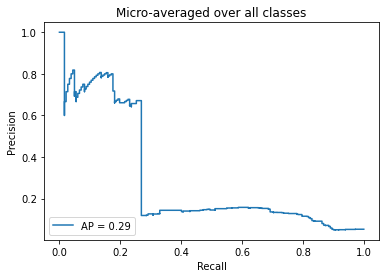

In [33]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Micro-averaged over all classes")

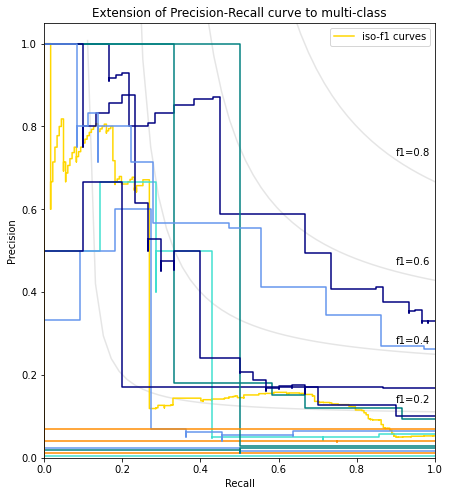

In [44]:
import matplotlib.pyplot as plt
from itertools import cycle

# setup plot details
colors = cycle(["navy", "turquoise", "darkorange", "cornflowerblue", "teal"])

_, ax = plt.subplots(figsize=(7, 8))

f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="gray", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot(ax=ax, name="Micro-average precision-recall", color="gold")

for i, color in zip(range(n_classes), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i],
        average_precision=average_precision[i],
    )
    display.plot(ax=ax, name=f"Precision-recall for class {i}", color=color)

# add the legend for the iso-f1 curves
# handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("Extension of Precision-Recall curve to multi-class")

plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score

# Import some data to play with
# iris = datasets.load_iris()
# X = iris.data
# y = iris.target
X = labeled_training_df.drop('label',axis=1)
y = labeled_training_df['label']

# Binarize the output
Y = label_binarize(y, classes=list(np.unique(y)))
n_classes = len(np.unique(y))

# Add noisy features to make the problem harder
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Learn to predict each class against the other
classifier = OneVsRestClassifier(
    svm.SVC(kernel="linear", probability=True, random_state=random_state)
)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 6 is present in all training examples.
  str(classes[c]))
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 12 is present in all training examples.
  str(classes[c]))
/Users/tiagoferreiraleao/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:813: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


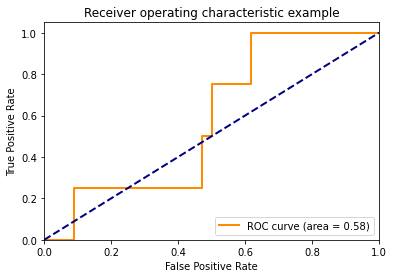

In [36]:
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

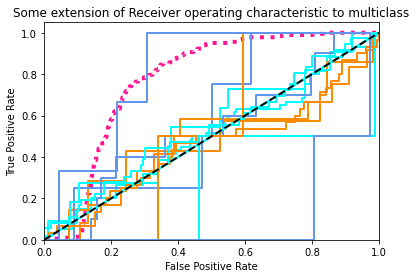

In [46]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
# plt.legend(loc="lower right")
plt.show()